In [1]:
# Resolve paths from models directory
import os
import sys

module_path = os.path.abspath(os.path.join("../models"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
import json

# models
from bag_of_models import BagOfModels

from imblearn.over_sampling import SMOTE, ADASYN

# data prep
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.feature_selection import RFECV
import util
import df_utils

# model evaluation
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)

In [9]:
FEATURE_DATA = "../saved/metadata_features.csv"
BOW_DATA = "../saved/final_datasets/bow_50words_10.csv"
TARGET_DATA = "../saved/binned_citations_threshold_2.csv"

In [10]:
features_cols = [
 'JournalNameRankNormalized',
 'PublisherRankNormalized',
 'NumberOfAuthors',
 'AuthorRank',
 'PageCount'
]

In [16]:
RAND_STATE = 0

def make_uniform(X, y):
    cc = SMOTE(random_state=RAND_STATE)
    X_resampled, y_resampled = cc.fit_sample(X, y)
    return X_resampled, y_resampled

def run_trial(bom, features, targets, cv=5, oversampling_rate=1):
    X, X_test, y, y_test = train_test_split(features, targets, test_size=0.1)
    X, y = util.get_uniform_version(X, y, oversampling_rate=oversampling_rate, random_state=RAND_STATE)
    #X, y = make_uniform(X, y)
    runs = ShuffleSplit(n_splits=cv, test_size=0.10, random_state=RAND_STATE)
    t_scores = []
    v_scores = []
    test_scores = []
    for train_idx, val_idx in runs.split(X):
        X_train, y_train = X[train_idx], y[train_idx]
        bom.fit(X_train, y_train)
        t_scores.append(bom.training_scores_)

        X_val, y_val = X[val_idx], y[val_idx]
        v_scores.append(bom.score(X_val, y_val))

        test_scores.append(bom.score(X_test, y_test))

    return t_scores, v_scores, test_scores, X, y, X_test, y_test

hyperparams = {
    'SVC': False,
    'LinearSVC': False,
    #'SVC': {
    #    'kernel': 'linear',
    #    'random_state': 0,
    #    'C': 10.0,
    #    'probability': True
    #},
    'NeuralNetwork': {
        'early_stopping': True,
        'random_state': 0, 
        'alpha': 1.0
    },
    # 'NaiveBayes': False,
    'RandomForest': {
        'max_depth': 10, 
        'min_samples_split': 0.01
    }, 
    'XGBoost': {
        'max_depth': 3
    }
}


In [17]:
bom = BagOfModels()
bom.hyperparams = hyperparams

oversampling_rate_scores = {}

for oversampling_rate in [1, 2, 3, 5, 10]:
    results = {}
    target_path = TARGET_DATA
    textual_features = df_utils.load_df(BOW_DATA).values
    metadata_features = df_utils.load_df(FEATURE_DATA).loc[:, features_cols].values
    target = df_utils.load_df(target_path).values.ravel()
    t_scores, v_scores, test_scores, X, y, X_test, y_test = run_trial(bom, metadata_features, target, cv=3, oversampling_rate=oversampling_rate)
    oversampling_rate_scores[oversampling_rate] = (t_scores, v_scores, test_scores)
    print("X shape, sampling rate={}".format(oversampling_rate))
    print(X.shape)
    print(v_scores)
    print(test_scores)

Fitting model:  NaiveBayes
Fitting model:  RandomForest
Fitting model:  NeuralNetwork
Fitting model:  XGBoost
Fitting model:  NaiveBayes
Fitting model:  RandomForest
Fitting model:  NeuralNetwork
Fitting model:  XGBoost
Fitting model:  NaiveBayes
Fitting model:  RandomForest
Fitting model:  NeuralNetwork
Fitting model:  XGBoost
X shape, sampling rate=1
(8646, 5)
[{'NaiveBayes': 0.4476650563607085, 'RandomForest': 0.7874865156418555, 'NeuralNetwork': 0.7591564927857934, 'XGBoost': 0.7846994535519125}, {'NaiveBayes': 0.44239631336405527, 'RandomForest': 0.7845659163987139, 'NeuralNetwork': 0.7649572649572649, 'XGBoost': 0.7835497835497836}, {'NaiveBayes': 0.4583333333333333, 'RandomForest': 0.7748917748917749, 'NeuralNetwork': 0.7927756653992396, 'XGBoost': 0.7652173913043477}]
[{'NaiveBayes': 0.23340321453529, 'RandomForest': 0.32642089093702, 'NeuralNetwork': 0.30836305984938567, 'XGBoost': 0.33125487139516757}, {'NaiveBayes': 0.23216783216783216, 'RandomForest': 0.3328125, 'NeuralNetw

In [18]:
for rate, all_scores in oversampling_rate_scores.items():
    print("Rate {} train scores:".format(rate))
    print(util.average_scores(t_scores))
    print("Rate {} test scores:".format(rate))
    t_scores, v_scores, test_scores = all_scores
    print(util.average_scores(test_scores))

Rate 1 train scores:
{'NaiveBayes': 0.5233015452439926, 'RandomForest': 0.9565568553350957, 'NeuralNetwork': 0.8871419332676069, 'XGBoost': 1.0}
Rate 1 test scores:
{'NaiveBayes': 0.2429221377213767, 'RandomForest': 0.31440468715940395, 'NeuralNetwork': 0.27168116612048127, 'XGBoost': 0.31306985323323716}


In [7]:
# From the last run
test_avg_scores = util.average_scores(test_scores)
test_avg_scores

{'NaiveBayes': 0.22997000836336015,
 'RandomForest': 0.30827660577106397,
 'NeuralNetwork': 0.3024648402119308,
 'XGBoost': 0.30676658972101245}

In [64]:
svc = bom.fit_models_["LinearSVC"]
nb = bom.fit_models_["NaiveBayes"]
rf = bom.fit_models_["RandomForest"]
nn = bom.fit_models_["NeuralNetwork"]
xgb = bom.fit_models_["XGBoost"]

In [65]:
import numpy as np
class_counts = np.unique(y_test, return_counts=True)
most_frequent_class = np.argmax(class_counts[1])
most_frequent_class

0

In [66]:
from sklearn.calibration import CalibratedClassifierCV 

svc_calibrated = CalibratedClassifierCV(svc)
svc_calibrated.fit(X, y)

CalibratedClassifierCV(base_estimator=SVC(C=1.0, break_ties=False,
                                          cache_size=200, class_weight=None,
                                          coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma='scale', kernel='rbf',
                                          max_iter=-1, probability=False,
                                          random_state=None, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv=None, method='sigmoid')

Most frequent baseline, accuracy & f1 score
0.9208456243854474
0.0


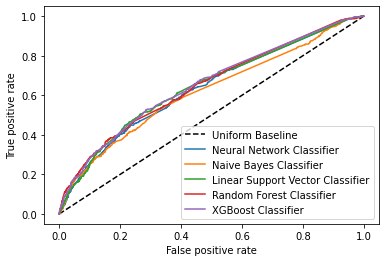

In [69]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score, accuracy_score, auc
import matplotlib.pyplot as plt

y_pred = nn.predict_proba(X_test)
tpr_grd_nn, fpr_grd_nn, _ = roc_curve(y_test, y_pred[:,1])

y_pred = nb.predict_proba(X_test)
tpr_grd_nb, fpr_grd_nb, _ = roc_curve(y_test, y_pred[:,1])

y_pred = svc_calibrated.predict_proba(X_test)
tpr_grd_svc, fpr_grd_svc, _ = roc_curve(y_test, y_pred[:,1])

y_pred = rf.predict_proba(X_test)
tpr_grd_rf, fpr_grd_rf, _ = roc_curve(y_test, y_pred[:,1])

y_pred = xgb.predict_proba(X_test)
tpr_grd_xgb, fpr_grd_xgb, _ = roc_curve(y_test, y_pred[:,1])

# Most frequent baseline
y_pred = [most_frequent_class] * len(y_pred)
tpr_grd_mfb, fpr_grd_mfb, _ = roc_curve(y_test, y_pred)
print("Most frequent baseline, accuracy & f1 score")
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

plt.figure(1)
#plt.plot(tpr_grd_mfb, fpr_grd_mfb, 'k--', label='Most Frequent Baseline')
plt.plot([0, 1], [0, 1], 'k--', label='Uniform Baseline')
plt.plot(tpr_grd_nn, fpr_grd_nn, label='Neural Network Classifier')
plt.plot(tpr_grd_nb, fpr_grd_nb, label='Naive Bayes Classifier')
plt.plot(tpr_grd_svc, fpr_grd_svc, label='Linear Support Vector Classifier')
plt.plot(tpr_grd_rf, fpr_grd_rf, label='Random Forest Classifier')
plt.plot(tpr_grd_xgb, fpr_grd_xgb, label='XGBoost Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

In [70]:
models = list(bom.fit_models_.items())

models.append(("SVC Calibrated", svc_calibrated))

for name, model in models:
    y_pred = model.predict(X_test)
    print(name)
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Accuracy:", model.score(X_test, y_test))
    if (name != "LinearSVC"):
        y_probs = model.predict_proba(X_test)
        fp_rate, tp_rate, thresholds = roc_curve(y_test, y_probs[:, 1])
        print("AUC Score:", roc_auc_score(y_test, y_probs[:, 1]))
        print("AUC score 2:", auc(fp_rate, tp_rate))
    print(confusion_matrix(y_test, y_pred, labels=[0,1]))
    print(classification_report(y_test, y_pred))


LinearSVC
F1 Score: 0.20455422616750285
Accuracy: 0.6622418879056047
[[3776 1843]
 [ 218  265]]
              precision    recall  f1-score   support

           0       0.95      0.67      0.79      5619
           1       0.13      0.55      0.20       483

    accuracy                           0.66      6102
   macro avg       0.54      0.61      0.50      6102
weighted avg       0.88      0.66      0.74      6102

NaiveBayes
F1 Score: 0.18741721854304638
Accuracy: 0.5978367748279253
AUC Score: 0.6191391820932897
AUC score 2: 0.6191391820932897
[[3365 2254]
 [ 200  283]]
              precision    recall  f1-score   support

           0       0.94      0.60      0.73      5619
           1       0.11      0.59      0.19       483

    accuracy                           0.60      6102
   macro avg       0.53      0.59      0.46      6102
weighted avg       0.88      0.60      0.69      6102

RandomForest
F1 Score: 0.19070403280929593
Accuracy: 0.6119305145853818
AUC Score: 0.648687

In [53]:
# Baseline
#tp = 0
#fp = 528
#fn = 528
#tn = 5574

tp = 3051
fp = 3051
fn = 3051
tn = 3051

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print("precision", precision)
print("recall", recall)

print("f1 score")
print(tp / (tp + 0.5*(fp+fn)))
print("accuracy")
print((tp+tn)/6102)

precision 0.5
recall 0.5
f1 score
0.5
accuracy
1.0


ZeroDivisionError: float division by zero